# Проект: классификация

In [1]:
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model, tree, ensemble, metrics, preprocessing

from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
# Исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [4]:
# Есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [5]:
# Преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.replace('$', '')
df['balance'] = df['balance'].str.replace(' ', '')
df['balance'] = df['balance'].str.replace(',00', '')

df['balance'] = df['balance'].astype(float)

round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [6]:
# Обработайте пропуски в признаке balance, заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [7]:
# Обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['education'].unique()

array(['secondary', 'tertiary', 'primary', 'unknown'], dtype=object)

In [8]:
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x=='unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x=='unknown' else x)

round(df[(df['job']==df['job'].mode()[0]) & (df['education']==df['education'].mode()[0])]['balance'].mean(), 3)

1598.883

### Задание 6

In [9]:
# Удалите все выбросы для признака balance
percentile_25 = np.percentile(df['balance'], 25)
percentile_75 = np.percentile(df['balance'], 75)
IQR = percentile_75 - percentile_25
left_bound = percentile_25 - 1.5 * IQR
right_bound = percentile_75 + 1.5 * IQR

df = df[(df['balance'] >= left_bound) & (df['balance'] <= right_bound)]

print(left_bound, right_bound, df.shape[0])

-2241.0 4063.0 10105


## Часть 2:  Разведывательный анализ

### Задание 1

no     54.0
yes    46.0
Name: deposit, dtype: float64 4681


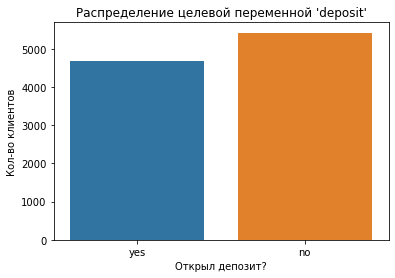

In [10]:
# Изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
print(round(df['deposit'].value_counts(normalize=True)*100), df['deposit'].value_counts()[1])

countplot = sns.countplot(df['deposit'])
countplot.set_title("Распределение целевой переменной 'deposit'")
countplot.set_xlabel('Открыл депозит?')
countplot.set_ylabel('Кол-во клиентов');

### Задания 2 и 3

In [11]:
# Рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [12]:
# Рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


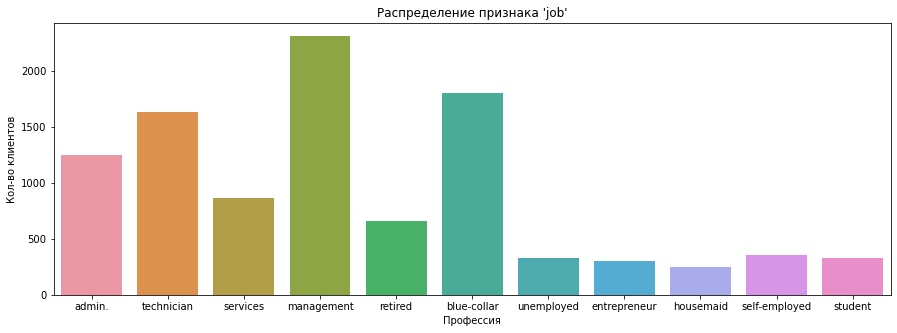

In [13]:
# Постройте визуализации, иллюстрирующие результаты
plt.figure(figsize=(15, 5))
countplot = sns.countplot(df['job'])
countplot.set_title("Распределение признака 'job'")
countplot.set_xlabel('Профессия')
countplot.set_ylabel('Кол-во клиентов');

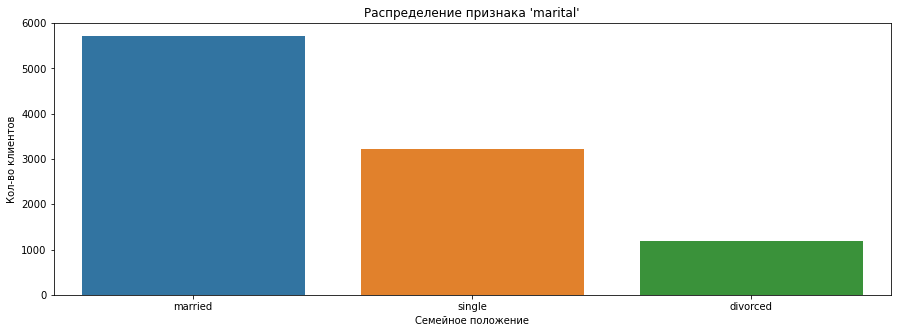

In [14]:
plt.figure(figsize=(15, 5))
countplot = sns.countplot(df['marital'])
countplot.set_title("Распределение признака 'marital'")
countplot.set_xlabel('Семейное положение')
countplot.set_ylabel('Кол-во клиентов');

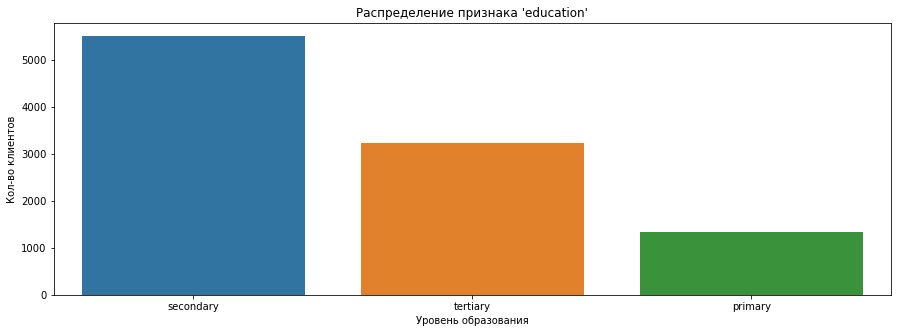

In [15]:
plt.figure(figsize=(15, 5))
countplot = sns.countplot(df['education'])
countplot.set_title("Распределение признака 'education'")
countplot.set_xlabel('Уровень образования')
countplot.set_ylabel('Кол-во клиентов');

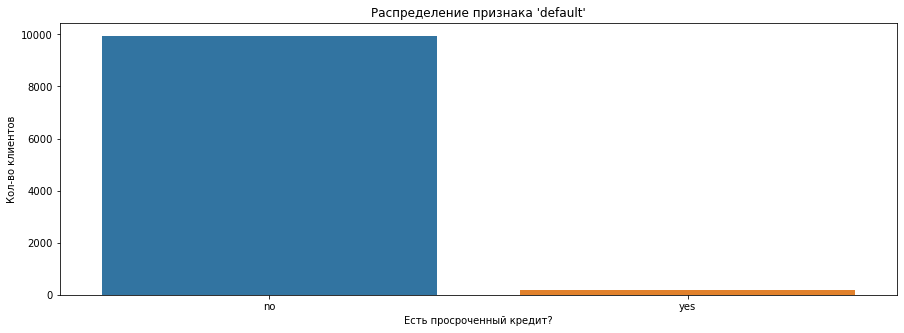

In [16]:
plt.figure(figsize=(15, 5))
countplot = sns.countplot(df['default'])
countplot.set_title("Распределение признака 'default'")
countplot.set_xlabel('Есть просроченный кредит?')
countplot.set_ylabel('Кол-во клиентов');

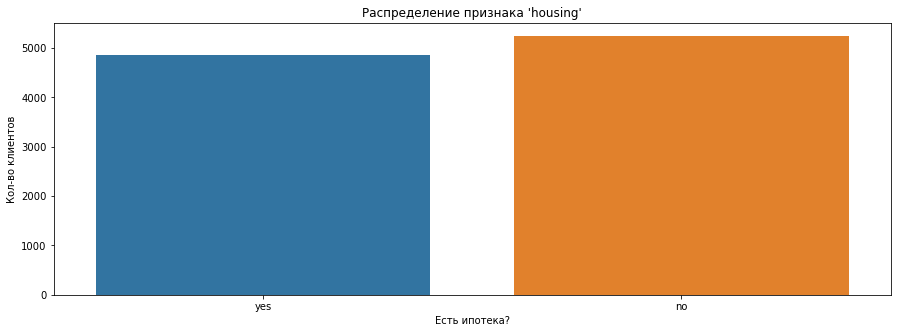

In [17]:
plt.figure(figsize=(15, 5))
countplot = sns.countplot(df['housing'])
countplot.set_title("Распределение признака 'housing'")
countplot.set_xlabel('Есть ипотека?')
countplot.set_ylabel('Кол-во клиентов');

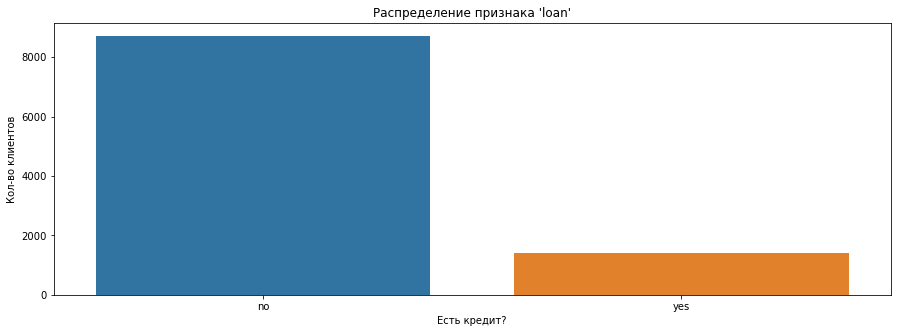

In [18]:
plt.figure(figsize=(15, 5))
countplot = sns.countplot(df['loan'])
countplot.set_title("Распределение признака 'loan'")
countplot.set_xlabel('Есть кредит?')
countplot.set_ylabel('Кол-во клиентов');

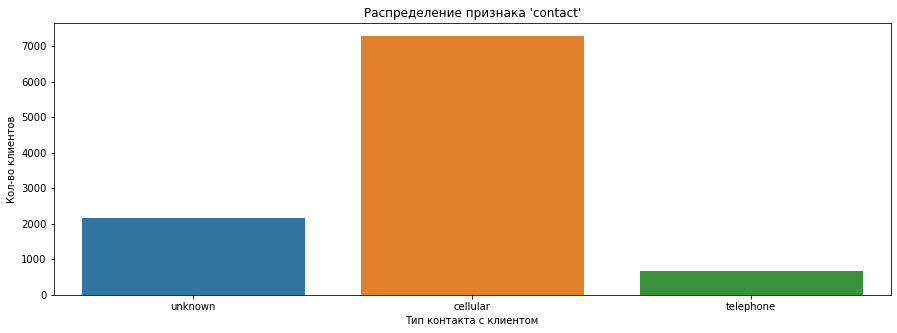

In [19]:
plt.figure(figsize=(15, 5))
countplot = sns.countplot(df['contact'])
countplot.set_title("Распределение признака 'contact'")
countplot.set_xlabel('Тип контакта с клиентом')
countplot.set_ylabel('Кол-во клиентов');

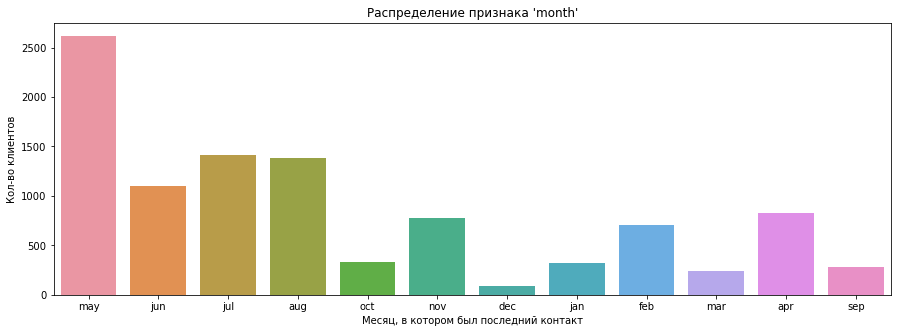

In [20]:
plt.figure(figsize=(15, 5))
countplot = sns.countplot(df['month'])
countplot.set_title("Распределение признака 'month'")
countplot.set_xlabel('Месяц, в котором был последний контакт')
countplot.set_ylabel('Кол-во клиентов');

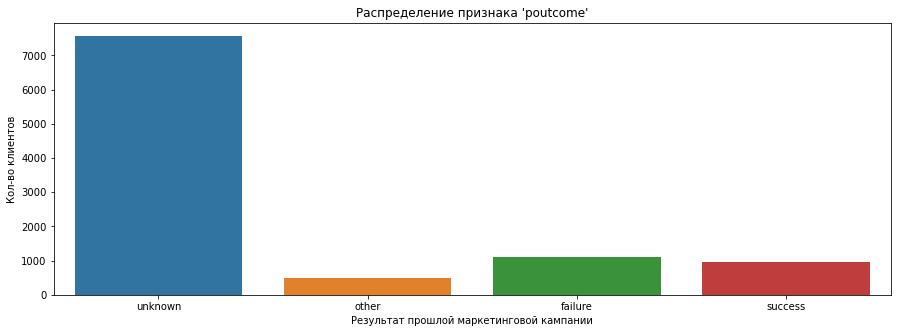

In [21]:
plt.figure(figsize=(15, 5))
countplot = sns.countplot(df['poutcome'])
countplot.set_title("Распределение признака 'poutcome'")
countplot.set_xlabel('Результат прошлой маркетинговой кампании')
countplot.set_ylabel('Кол-во клиентов');

### Задание 6

In [22]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач
df.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

### Задание 7

In [23]:
# Узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
months_list = list(df['month'].unique())
for month in months_list:
    print(month, round(df[df['month']==month]['deposit'].value_counts(normalize=True)*100)['no'])

may 68.0
jun 55.0
jul 59.0
aug 56.0
oct 19.0
nov 58.0
dec 10.0
jan 61.0
feb 46.0
mar 10.0
apr 38.0
sep 17.0


### Задание 8

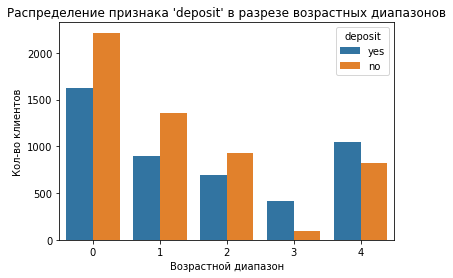

In [24]:
# Создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['age_group'] = pd.cut(df.age, [0, 30, 40, 50, 60, 9999], labels = ['<30','30-40','40-50','50-60','60+'])
encoder = LabelEncoder()
df["age_group"] = encoder.fit_transform(df['age_group'])

countplot = sns.countplot(df['age_group'], hue=df['deposit'])
countplot.set_title("Распределение признака 'deposit' в разрезе возрастных диапазонов")
countplot.set_xlabel('Возрастной диапазон')
countplot.set_ylabel('Кол-во клиентов');

### Задания 9 и 10

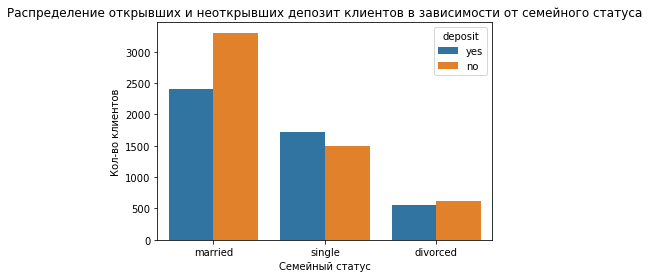

In [25]:
# Постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
countplot = sns.countplot(df['marital'], hue=df['deposit'])
countplot.set_title('Распределение открывших и неоткрывших депозит клиентов в зависимости от семейного статуса')
countplot.set_xlabel('Семейный статус')
countplot.set_ylabel('Кол-во клиентов');

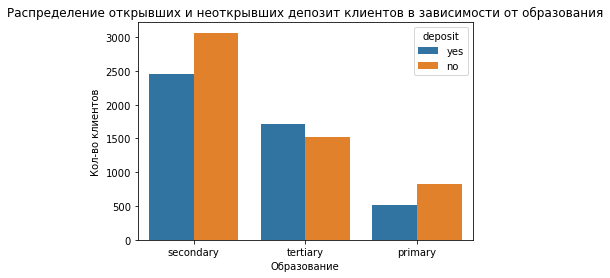

In [26]:
# Постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
countplot = sns.countplot(df['education'], hue=df['deposit'])
countplot.set_title('Распределение открывших и неоткрывших депозит клиентов в зависимости от образования')
countplot.set_xlabel('Образование')
countplot.set_ylabel('Кол-во клиентов');

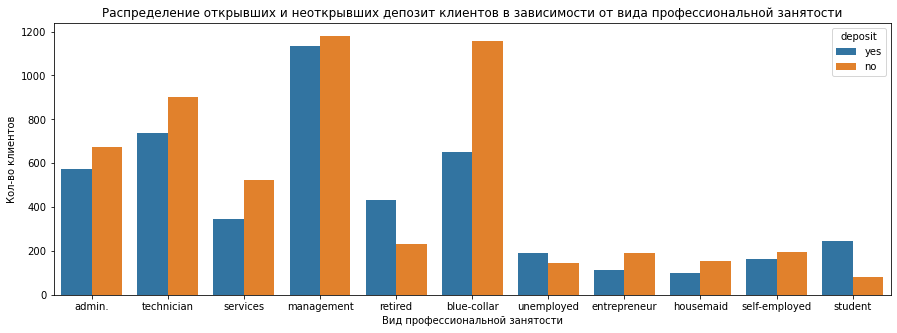

In [27]:
# Постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
plt.figure(figsize=(15, 5))
countplot = sns.countplot(df['job'], hue=df['deposit'])
countplot.set_title('Распределение открывших и неоткрывших депозит клиентов в зависимости от вида профессиональной занятости')
countplot.set_xlabel('Вид профессиональной занятости')
countplot.set_ylabel('Кол-во клиентов');

In [28]:
df['job'].mode()[0]

'management'

### Задание 11

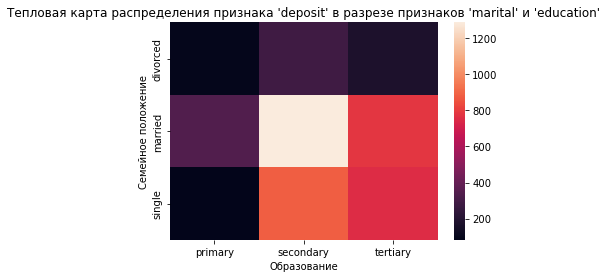

In [29]:
# Постройте сводную таблицу, чтобы определить, люди с каким образованием и семейным статусом наиболее многочисленны
# (если рассматривать тех, кто открыл депозит)
deposit_yes = df[df['deposit']=='yes'][['marital', 'education', 'deposit']]
crosstab = pd.crosstab(deposit_yes['marital'], deposit_yes['education'])

heatmap = sns.heatmap(crosstab)
heatmap.set_title("Тепловая карта распределения признака 'deposit' в разрезе признаков 'marital' и 'education'")
heatmap.set_xlabel('Образование')
heatmap.set_ylabel('Семейное положение');

## Часть 3: преобразование данных

### Задание 1

In [30]:
# Преобразуйте уровни образования
encoder = preprocessing.LabelEncoder()
df['education'] = encoder.fit_transform(df['education'])
df['education'].sum()

11995

### Задания 2 и 3

In [31]:
# Преобразуйте бинарные переменные в представление из нулей и единиц
df['deposit'] = df['deposit'].replace(['yes', 'no'], [1, 0])
df['default'] = df['default'].replace(['yes', 'no'], [1, 0])
df['housing'] = df['housing'].replace(['yes', 'no'], [1, 0])
df['loan'] = df['loan'].replace(['yes', 'no'], [1, 0])

print(round(df['deposit'].std(), 3), round(df['default'].mean() + df['housing'].mean() + df['loan'].mean(), 3))

0.499 0.635


### Задание 4

In [32]:
# Создайте дамми-переменные
df_dummies = pd.get_dummies(df[['job', 'marital', 'contact', 'month', 'poutcome']])
df = pd.concat([df, df_dummies], axis=1)

print(df.shape[1])

df = df.drop(['job', 'marital', 'contact', 'month', 'poutcome'], axis=1)

51


### Задания 5 и 6

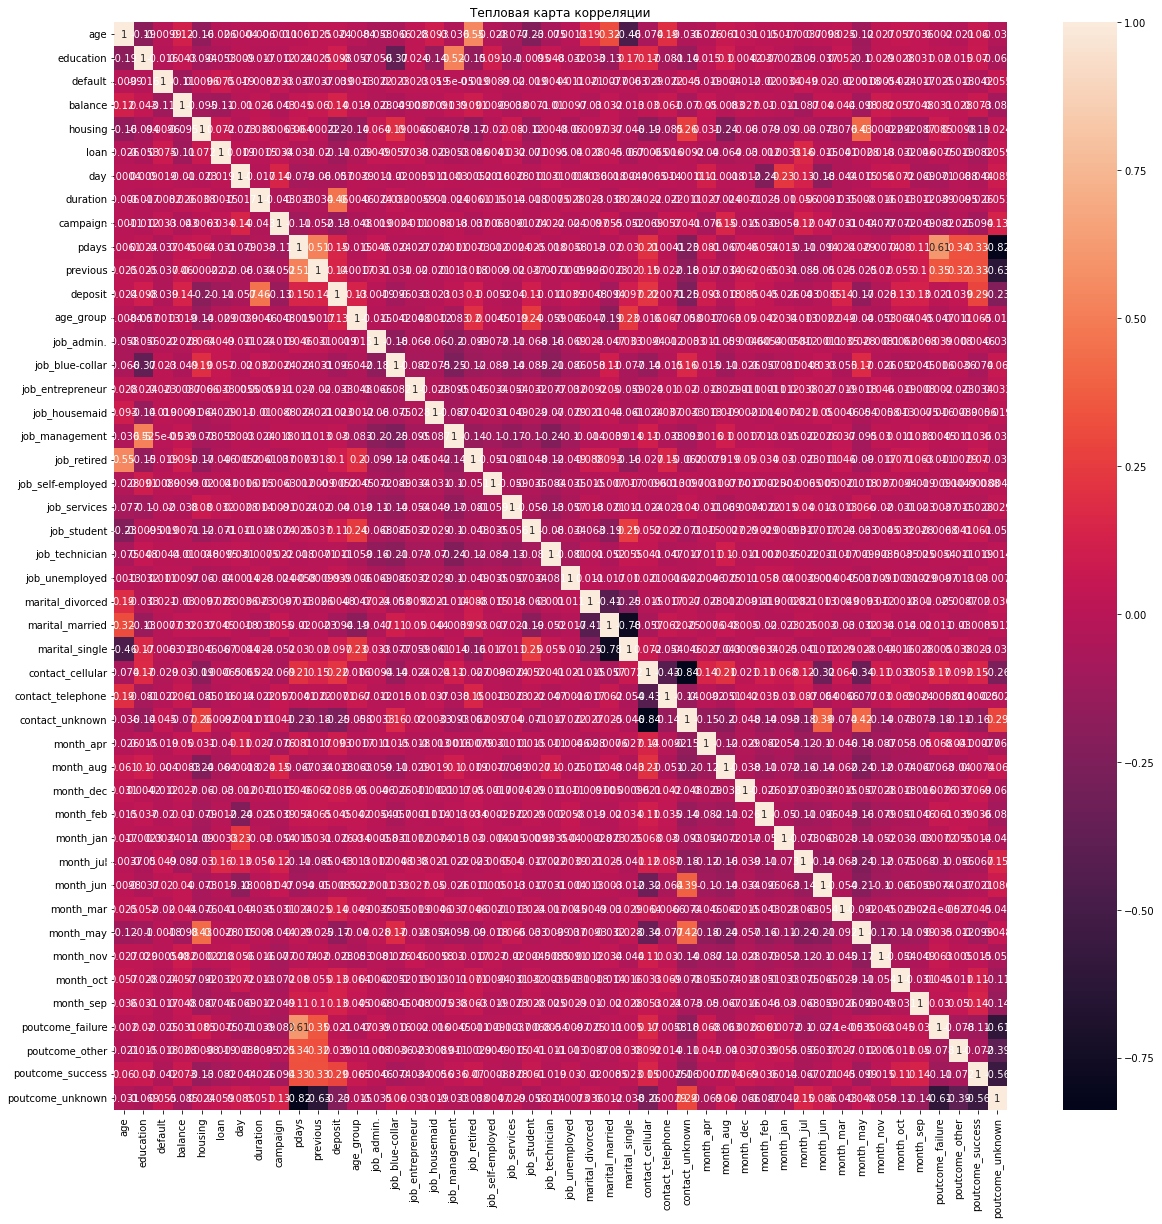

In [33]:
# Постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(20, 20))
corr_data = df.corr()

heatmap = sns.heatmap(corr_data, annot=True)
heatmap.set_title("Тепловая карта корреляции");

### Задания 7 и 8

In [34]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)

In [35]:
# Рассчитайте необходимые показатели
print(X_test.shape[0], round(y_test.mean(), 2))

3335 0.46


### Задание 9

In [36]:
# С помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
columns_list = list(selector.get_feature_names_out())
df = pd.concat([df[columns_list], df['deposit']], axis=1)
columns_list

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [37]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)

In [38]:
# Нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
norm_names = ['balance', 'duration', 'campaign', 'pdays']

scaler.fit(X_train[norm_names])

X_train[norm_names] = scaler.transform(X_train[norm_names])
X_test[norm_names] = scaler.transform(X_test[norm_names])

round(X_test.iloc[:, 0].mean(), 2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [39]:
# Обучите логистическую регрессию и рассчитайте метрики качества
model = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)

model.fit(X_train, y_train)

round(model.score(X_test, y_test), 2)

0.81

### Задания 2,3,4

In [40]:
# Обучите решающие деревья, настройте максимальную глубину
model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(metrics.classification_report(y_train, y_train_pred), metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770
               precision    recall  f1-score   support

           0       0.76      0.77      0.77      1790
           1       0.73      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



In [41]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(metrics.classification_report(y_train, y_train_pred), metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      3634
           1       0.77      0.86      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770
               precision    recall  f1-score   support

           0       0.85      0.77      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

In [42]:
# Подберите оптимальные параметры с помощью gridsearch
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}

model = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

round(metrics.f1_score(y_test, y_test_pred), 2)

0.8

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [43]:
# Обучите на ваших данных случайный лес
model = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42)

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [44]:
# Используйте для классификации градиентный бустинг и сравните качество со случайным лесом
model = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42)

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [45]:
# Объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('log_reg', linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)),
    ('dec_tree', tree.DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)),
    ('grad_boost', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42))
]

model = ensemble.StackingClassifier(estimators, final_estimator=linear_model.LogisticRegression(random_state=42))

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [46]:
# Оцените, какие признаки демонстрируют наибольшую важность в модели градиентного бустинга
model = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42)

model.fit(X_train, y_train)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).nlargest(3)

duration            0.507106
poutcome_success    0.114958
contact_unknown     0.072582
dtype: float64

### Задания 6,7,8

In [47]:
# Реализуйте оптимизацию гиперпараметров с помощью Optuna
# Инициализируем функцию Оптуна для подсчёта метрики на модели случайного леса
def optuna_rf(trial):
    # Задаём пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42)

    model.fit(X_train, y_train)
    
    score = metrics.f1_score(y_train, model.predict(X_train))

    return score

# Создаём объект исследования и напрямую указываем, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2024-04-16 15:18:05,156] A new study created in memory with name: RandomForestClassifier
[I 2024-04-16 15:18:06,367] Trial 0 finished with value: 0.8670520231213874 and parameters: {'n_estimators': 122, 'max_depth': 24, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8670520231213874.
[I 2024-04-16 15:18:07,655] Trial 1 finished with value: 0.8861076345431789 and parameters: {'n_estimators': 123, 'max_depth': 18, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8861076345431789.
[I 2024-04-16 15:18:09,620] Trial 2 finished with value: 0.8938232994526973 and parameters: {'n_estimators': 186, 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8938232994526973.
[I 2024-04-16 15:18:10,708] Trial 3 finished with value: 0.8626157952582822 and parameters: {'n_estimators': 115, 'max_depth': 13, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8938232994526973.
[I 2024-04-16 15:18:11,978] Trial 4 finished with value: 0.845357590966123 and parameters: {'n_e

[I 2024-04-16 15:19:17,342] Trial 38 finished with value: 0.8796498905908096 and parameters: {'n_estimators': 195, 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 10 with value: 0.9247683367362965.
[I 2024-04-16 15:19:18,501] Trial 39 finished with value: 0.8564735280337342 and parameters: {'n_estimators': 123, 'max_depth': 17, 'min_samples_leaf': 7}. Best is trial 10 with value: 0.9247683367362965.
[I 2024-04-16 15:19:20,498] Trial 40 finished with value: 0.8938564952321401 and parameters: {'n_estimators': 187, 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 10 with value: 0.9247683367362965.
[I 2024-04-16 15:19:22,758] Trial 41 finished with value: 0.9222797927461139 and parameters: {'n_estimators': 197, 'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 10 with value: 0.9247683367362965.
[I 2024-04-16 15:19:25,057] Trial 42 finished with value: 0.9238259776975027 and parameters: {'n_estimators': 200, 'max_depth': 27, 'min_samples_leaf': 2}. Best is trial 10 with va

Наилучшие значения гиперпараметров {'n_estimators': 199, 'max_depth': 25, 'min_samples_leaf': 2}


In [48]:
model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



## Итоговый вывод

Мы справились с настоящим проектом, решив достаточно сложную, но важную и популярную в индустрии задачу. Теперь мы можем решить полноценную задачу классификации, начиная от предобработки данных и заканчивая оценкой качества построенных моделей и отбора наиболее значимых предикторов.